In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance

from hnmchallenge.constant import *
from hnmchallenge.data_reader import DataReader

from hnmchallenge.evaluation.python_evaluation import map_at_k, recall_at_k
from hnmchallenge.feature_manager import FeatureManager
from hnmchallenge.datasets.last_week_last_week import LWLWDataset
from hnmchallenge.datasets.last_month_last_week_dataset import LMLWDataset

from hnmchallenge.models.itemknn.itemknn import ItemKNN




/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
dataset = LMLWDataset()
dr = DataReader()

In [3]:
base_load_path = dataset._DATASET_PATH / "xgb_models"

In [4]:
VERSION = 0
NAME = "cutf_40_Popularity_cutoff_40"
DATASET = f"{NAME}_{VERSION}.feather"
MODEL_NAME = f"xgb_{DATASET}.json"

In [5]:
model = xgb.XGBRanker()
model.load_model(base_load_path/MODEL_NAME)

In [6]:
from xgboost import plot_importance

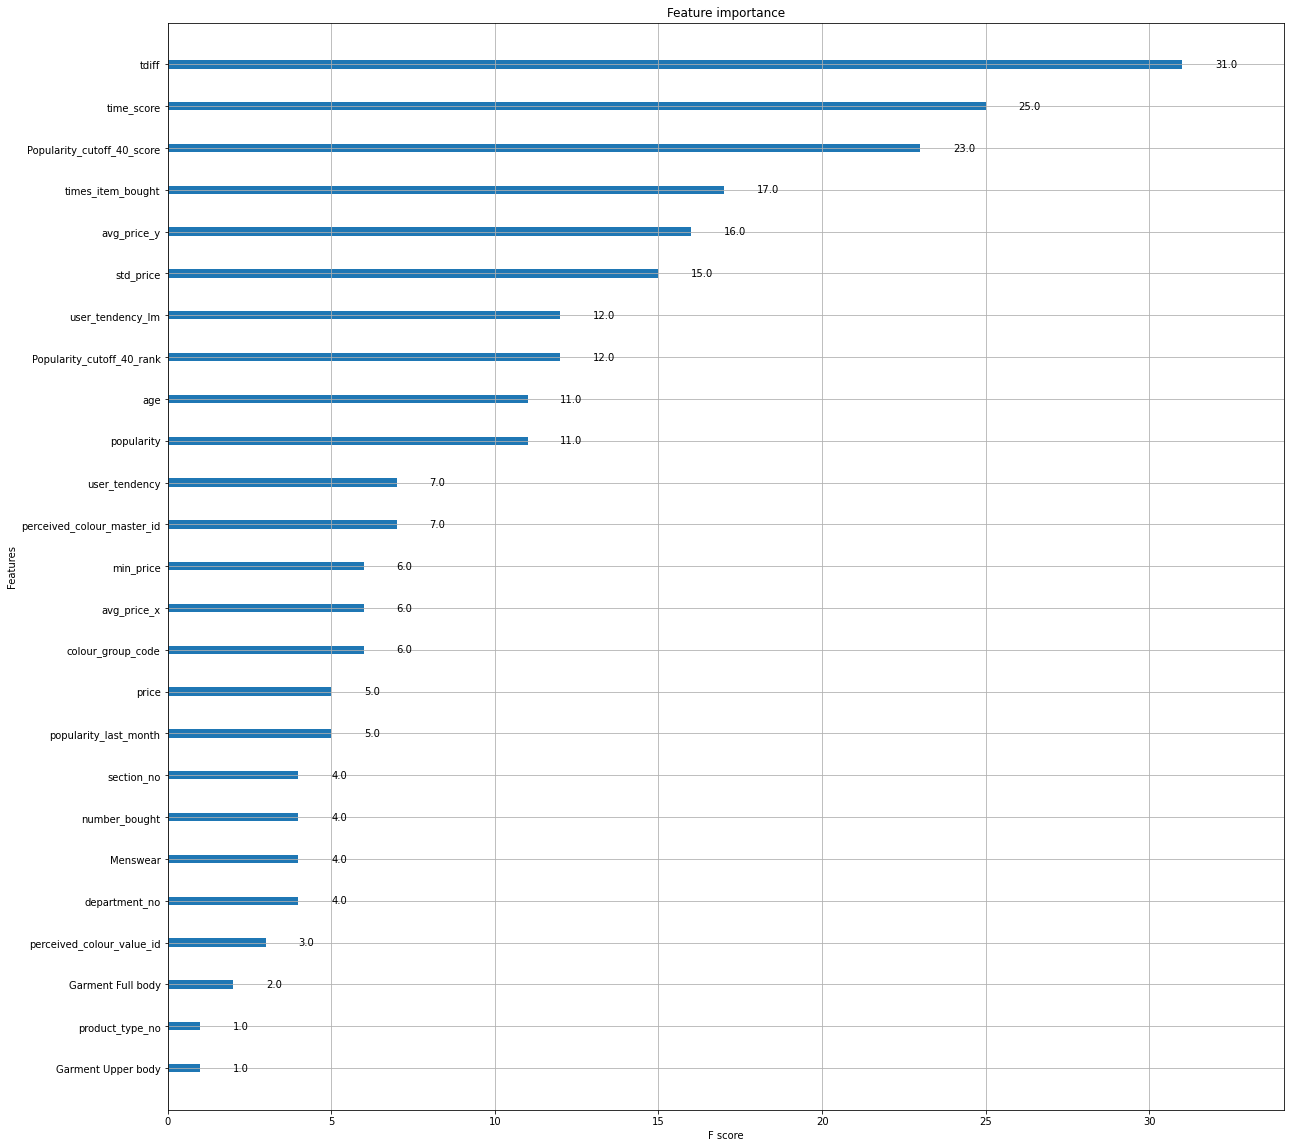

In [7]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_importance(model, ax=ax)
plt.show()

In [8]:
model.best_ntree_limit

24

In [9]:
features = pd.read_feather(dataset._DATASET_PATH / f"dataset_dfs/full/{DATASET}")

# Remember to use the bert_ntree_limit when taking the predictions

In [10]:
features.head()

,customer_id,article_id,Popularity_cutoff_40_score,Popularity_cutoff_40_rank,colour_group_code,department_no,Baby/Children,Divided,Ladieswear,Menswear,...,Monthly,NONE,None,Regularly,avg_price_y,user_tendency,user_tendency_lm,time_score,tdiff,times_item_bought
0,0,7,0.607774,16.0,9,1616,0,0,1,0,...,0,1,0,0,0.026973,0.2,NaN,NaN,NaN,NaN
1,0,197,0.836951,7.0,72,1747,0,1,0,0,...,0,1,0,0,0.026973,0.2,NaN,NaN,NaN,NaN
2,0,397,0.497728,27.0,9,3608,0,0,1,0,...,0,1,0,0,0.026973,0.2,NaN,NaN,NaN,NaN
3,0,2067,0.792024,10.0,9,1747,0,1,0,0,...,0,1,0,0,0.026973,0.2,NaN,1.0,0.004855,1.0
4,0,2165,0.508329,24.0,9,1643,0,1,0,0,...,0,1,0,0,0.026973,0.2,NaN,NaN,NaN,NaN


In [11]:
customer_article_df = features[[DEFAULT_USER_COL, DEFAULT_ITEM_COL]].copy()
X = features.drop([DEFAULT_USER_COL, DEFAULT_ITEM_COL], axis=1)

In [12]:
X.head()

,Popularity_cutoff_40_score,Popularity_cutoff_40_rank,colour_group_code,department_no,Baby/Children,Divided,Ladieswear,Menswear,Sport,popularity,...,Monthly,NONE,None,Regularly,avg_price_y,user_tendency,user_tendency_lm,time_score,tdiff,times_item_bought
0,0.607774,16.0,9,1616,0,0,1,0,0,0.135736,...,0,1,0,0,0.026973,0.2,NaN,NaN,NaN,NaN
1,0.836951,7.0,72,1747,0,1,0,0,0,0.297865,...,0,1,0,0,0.026973,0.2,NaN,NaN,NaN,NaN
2,0.497728,27.0,9,3608,0,0,1,0,0,0.420072,...,0,1,0,0,0.026973,0.2,NaN,NaN,NaN,NaN
3,0.792024,10.0,9,1747,0,1,0,0,0,1.000000,...,0,1,0,0,0.026973,0.2,NaN,1.0,0.004855,1.0
4,0.508329,24.0,9,1643,0,1,0,0,0,0.048905,...,0,1,0,0,0.026973,0.2,NaN,NaN,NaN,NaN


In [13]:
y_pred = model.predict(X, ntree_limit=model.best_ntree_limit)

/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [14]:
customer_article_df["predicted_score"] = y_pred

In [15]:
customer_article_df

,customer_id,article_id,predicted_score
0,0,7,0.124381
1,0,197,0.460552
2,0,397,0.029339
3,0,2067,1.475906
4,0,2165,-0.003964
...,...,...,...
54879195,1371979,23722,0.466278
54879196,1371979,23741,0.010383
54879197,1371979,23763,0.568475
54879198,1371979,24263,0.063974


In [16]:
sorted_scores = customer_article_df.sort_values([DEFAULT_USER_COL, "predicted_score"], ascending=[True, False])

In [17]:
sorted_scores

,customer_id,article_id,predicted_score
5,0,2257,1.482254
3,0,2067,1.475906
30,0,23245,0.583998
37,0,23763,0.568475
7,0,4463,0.490090
...,...,...,...
54879185,1371979,21754,0.016021
54879196,1371979,23741,0.010383
54879166,1371979,4275,0.000946
54879164,1371979,2165,-0.003964


In [18]:
sorted_scores_index = sorted_scores.reset_index(drop=True)

In [19]:
cutoff = sorted_scores_index.groupby(DEFAULT_USER_COL).size().values
i=0 
filter_indices = []
for cut in cutoff:
    filter_indices.extend(range(i, i+12))
    i=i+cut

In [20]:
cutoff.mean()

40.0

In [25]:
filter_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 440,
 441,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 560,
 561,
 562,
 563,
 564,
 565,
 5

In [21]:
final_df = sorted_scores_index.loc[filter_indices]

In [22]:
final_df

,customer_id,article_id,predicted_score
0,0,2257,1.482254
1,0,2067,1.475906
2,0,23245,0.583998
3,0,23763,0.568475
4,0,4463,0.490090
...,...,...,...
54879167,1371979,21139,0.426914
54879168,1371979,23392,0.426839
54879169,1371979,20971,0.422774
54879170,1371979,2067,0.413198


In [23]:
final_final_df = final_df.drop("predicted_score", axis=1)

In [24]:
dataset.create_submission(final_final_df, sub_name="no_time_f")